# Multi-class classification of dog breeds

## Getting started

In [3]:
!pip -q install torch==1.13.1 torchvision==0.14.1 gradio==3.47.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 k

In [8]:
# !pip -q install pip --upgrade
# !pip -q install kaleido
# !pip -q install typing-extensions

In [1]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict, Tuple
import pandas as pd
import numpy as np
import shutil
import os
import random
import glob

In [2]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu117
torchvision version: 0.14.1+cu117


In [3]:
try:
  from torchinfo import summary
except:
  print("[INFO] Installing torchinfo .")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from modular import engine, utils
  from modular.assist import set_seeds, plot_loss_curves
except:
  print("[INFO] Downloading from GitHub.")
  !git clone https://github.com/amunipelumi/foodvision-mini
  !mv foodvision-mini/modular .
  !rm -rf foodvision-mini
  from modular import engine, utils
  from modular.assist import set_seeds, plot_loss_curves

[INFO] Installing torchinfo .
[INFO] Downloading from GitHub.
Cloning into 'foodvision-mini'...
remote: Enumerating objects: 654, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 654 (delta 10), reused 14 (delta 4), pack-reused 629
Receiving objects: 100% (654/654), 87.87 MiB | 40.97 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:
import gradio as gr
print(f"\ngradio version: {gr.__version__}")


gradio version: 3.47.1


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# !unzip "drive/MyDrive/DogVision/dog-breed-identification.zip" -d "drive/MyDrive/DogVision"

In [7]:
label_csv = pd.read_csv("drive/MyDrive/DogVision/labels.csv")
label_csv.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [8]:
label_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


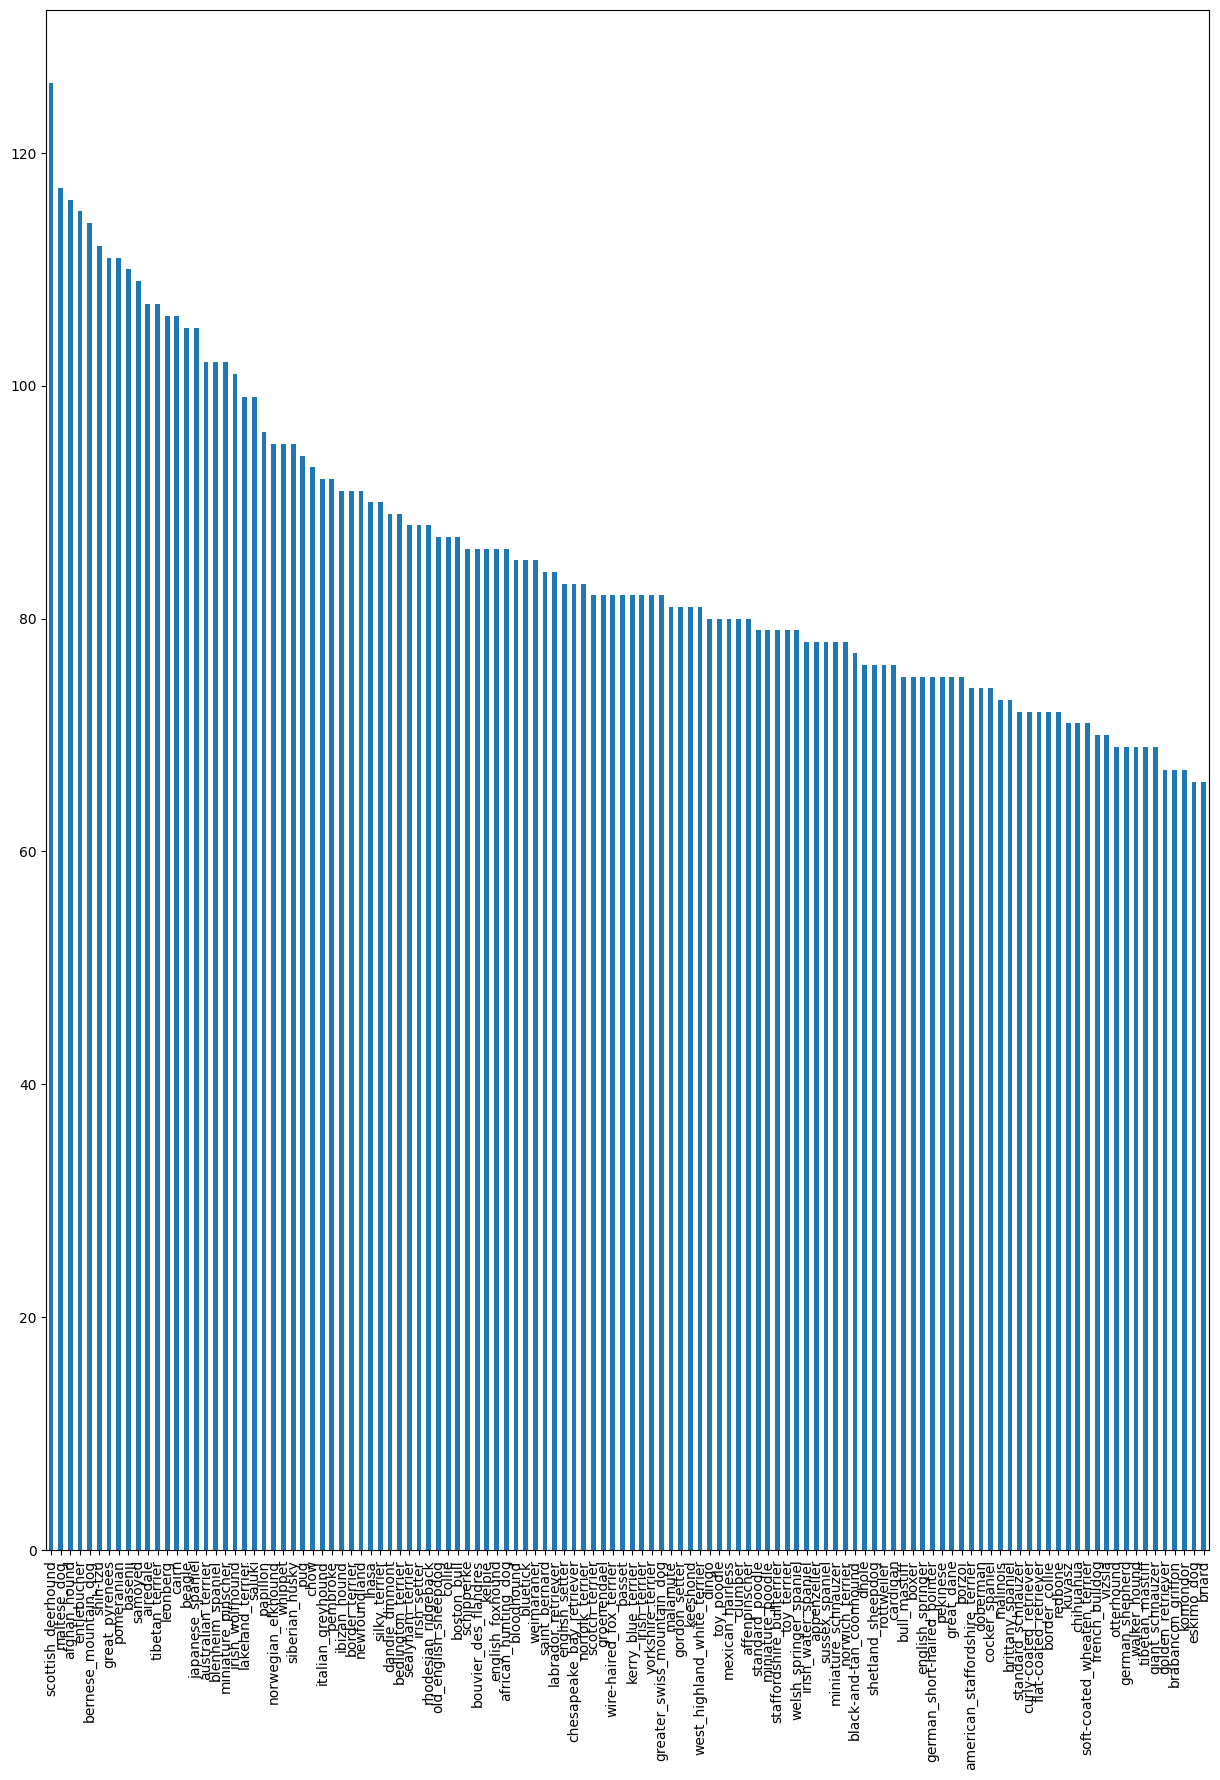

In [9]:
label_csv.breed.value_counts().plot.bar(figsize=(15,20));

In [10]:
label_csv.breed.value_counts().median(), len(label_csv)

(82.0, 10222)

In [11]:
base_dir = Path('drive/MyDrive/DogVision/train/')

for index, row in label_csv.iterrows():

  id = row['id']
  breed = row['breed']

  full_id = id + '.jpg'
  breed_dirs = os.path.join(base_dir, breed)

  if not os.path.exists(breed_dirs):
    os.makedirs(breed_dirs)

  source = os.path.join(base_dir, full_id)
  dest = breed_dirs

  if os.path.exists(source) and (breed == Path(breed_dirs).name):
    shutil.move(src=source, dst=dest)


In [12]:
# directories = os.listdir(base_dir)

# for dir in directories:
#   print(dir)

# print(f"\nlength of all sub-directories: {len(directories)}")

all_files = glob.glob("drive/MyDrive/DogVision/train/*/*.*")
print(f"length of all files: {len(all_files)}\n")
all_files[:2]

length of all files: 10222



['drive/MyDrive/DogVision/train/boston_bull/010d65bd29d246aea53d9849da142ccf.jpg',
 'drive/MyDrive/DogVision/train/boston_bull/000bec180eb18c7604dcecc8fe0dba07.jpg']

In [13]:
folder_path = "drive/MyDrive/DogVision/train/"
total_size = 0

for filename in os.listdir(folder_path):
  file_path = os.path.join(folder_path, filename)
  # print(file_path)
  if os.path.isfile(file_path):
    total_size += os.path.getsize(file_path)

# this should me know if all files moved correctly
print(f"Total size of files in {folder_path} is {total_size} bytes")

Total size of files in drive/MyDrive/DogVision/train/ is 0 bytes


In [14]:
breeds = np.unique(label_csv.breed)
print(f"length of breeds: {len(breeds)}\n")
breeds

length of breeds: 120



array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [15]:
weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
effnet3_transforms = weights.transforms()
effnet3 = torchvision.models.efficientnet_b3(weights=weights)

for param in effnet3.parameters():
  param.requires_grad = False

effnet3.classifier

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

In [16]:
def create_model(num_classes=1000, seed=13):

  """Creates an EfficientNetB2 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier head.
          Defaults to 1000.
      seed (int, optional): random seed value. Defaults to 13.

  Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """

  weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
  auto_transforms = weights.transforms()
  model = torchvision.models.efficientnet_b3(weights=weights)

  manual_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    auto_transforms
  ])

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=num_classes)
  )

  return model, auto_transforms, manual_transforms

model, auto_transforms, manual_transforms = create_model(len(breeds))

In [17]:
print(f"auto transforms:\n{auto_transforms}\n")
print(f"manual transforms:\n{manual_transforms}")

auto transforms:
ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

manual transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)


In [18]:
summary(model=model,
        input_size=(1, 3, 300, 300),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 300, 300]     [1, 120]             --                   Partial
├─Sequential (features)                                      [1, 3, 300, 300]     [1, 1536, 10, 10]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 300, 300]     [1, 40, 150, 150]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 300, 300]     [1, 40, 150, 150]    (1,080)              False
│    │    └─BatchNorm2d (1)                                  [1, 40, 150, 150]    [1, 40, 150, 150]    (80)                 False
│    │    └─SiLU (2)                                         [1, 40, 150, 150]    [1, 40, 150, 150]    --                   --
│    └─Sequential (1)                                        [1, 40, 150, 150]    [1, 2

## Getting data

In [19]:
base_dir

PosixPath('drive/MyDrive/DogVision/train')

In [20]:
dataset = datasets.ImageFolder(root=base_dir,
                               transform=manual_transforms)

print(f"{dataset}\n")
print(f"length of classes: {len(dataset.classes)}\n")

class_names = dataset.classes
class_names[:5]

Dataset ImageFolder
    Number of datapoints: 10222
    Root location: drive/MyDrive/DogVision/train
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ImageClassification(
               crop_size=[300]
               resize_size=[320]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
           )

length of classes: 120



['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

In [21]:
def split_dataset(dataset, split_size=0.25, seed:int=13):

  """Randomly splits a given dataset into two proportions based on split_size and seed.

  Args:
      dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
      split_size (float, optional): How much of the dataset should be split?
          E.g. split_size=0.25 means there will be a 25% split and an 75% split. Defaults to 0.25.
      seed (int, optional): Seed for random generator. Defaults to 13.

  Returns:
      tuple: (big_split, small_split)

  """

  small_portion = int(len(dataset) * split_size)
  big_portion = len(dataset) - small_portion

  big = int((1-split_size)*100)
  small = int(split_size*100)

  print(f"[INFO] Splitting {len(dataset)} to: {big_portion} ({big}%) and {small_portion} ({small}%)\n")

  big_split, small_split = random_split(dataset,
                                        lengths=[big_portion, small_portion],
                                        generator=torch.manual_seed(seed))
  return big_split, small_split

In [22]:
train_split , test_split = split_dataset(dataset=dataset)

len(train_split), len(test_split)

[INFO] Splitting 10222 to: 7667 (75%) and 2555 (25%)



(7667, 2555)

In [23]:
BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4

train_loader = DataLoader(dataset=train_split,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

test_loader = DataLoader(dataset=test_split,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7936adada1a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7936adad8310>)

## Training model

In [24]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds(13)
model_results = engine.train(model=model,
                             train_dataloader=train_loader,
                             test_dataloader=test_loader,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=3,
                             device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3480 | train_acc: 0.4482 | test_loss: 2.4966 | test_acc: 0.6916
Epoch: 2 | train_loss: 2.0867 | train_acc: 0.6936 | test_loss: 1.8656 | test_acc: 0.7354
Epoch: 3 | train_loss: 1.8130 | train_acc: 0.7474 | test_loss: 1.8959 | test_acc: 0.7505


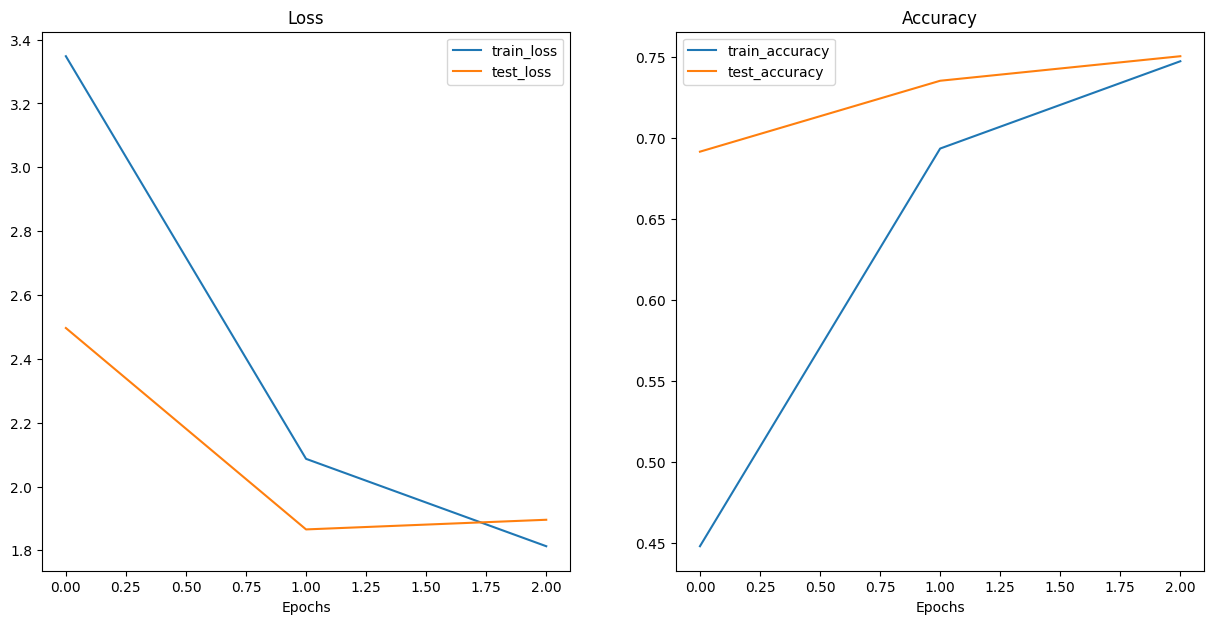

In [25]:
plot_loss_curves(model_results)

## Save model

In [26]:
utils.save_model(model=model,
                 target_dir="drive/MyDrive/DogVision/models",
                 model_name="effnetb3_dog_vision.pth")

[INFO] Saving model to: drive/MyDrive/DogVision/models/effnetb3_dog_vision.pth


In [27]:
loaded_model, transforms, _ = create_model(len(breeds))
loaded_model.load_state_dict(torch.load("drive/MyDrive/DogVision/models/effnetb3_dog_vision.pth"))

<All keys matched successfully>

In [28]:
model_size = Path("drive/MyDrive/DogVision/models/effnetb3_dog_vision.pth").stat().st_size // (1024*1024)
print(f"Model size: {model_size} MB")

Model size: 42 MB


In [29]:
total_params = sum(torch.numel(param) for param in loaded_model.parameters())
total_params

10880672

In [30]:
stats = {"test_loss": round(model_results["test_loss"][-1], 2),
          "test_acc": round(model_results["test_acc"][-1], 2),
          "number_of_parameters": total_params,
          "model_size (MB)": model_size}
stats

{'test_loss': 1.9,
 'test_acc': 0.75,
 'number_of_parameters': 10880672,
 'model_size (MB)': 42}

## Predicting with model

In [31]:
# base_dir = Path('drive/MyDrive/DogVision/train/')
# my_test = Path('drive/MyDrive/DogVision/myTest/')

# for index, row in label_csv.iterrows():

#   id = row['id']
#   breed = row['breed']

#   full_id = id + '.jpg'
#   test_dirs = os.path.join(my_test, breed)

#   if not os.path.exists(test_dirs):
#     os.makedirs(test_dirs)

#   source = os.path.join(base_dir, full_id)
#   dest = test_dirs

#   if os.path.exists(source) and (breed == Path(test_dirs).name):
#     shutil.copy2(src=source, dst=dest)

In [32]:
def pred_and_store(paths: List[Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  pred_list = []

  for path in tqdm(paths):

    pred_dict = {}

    pred_dict["image_path"] = path
    pred_dict["class_name"] = path.parent.stem

    start_time = timer()

    img = Image.open(path)

    transformed_image = transform(img).unsqueeze(0).to(device)

    model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)

      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = class_names[pred_label.cpu()]

      end_time = timer()
      pred_dict["time_for_pred (s)"] = round(end_time-start_time, 4)

    pred_dict["correct"] = pred_dict["class_name"] == pred_dict["pred_class"]

    pred_list.append(pred_dict)

  return pred_list

In [33]:
def pred_and_plot(paths: List[Path],
                  model: torch.nn.Module,
                  transform: torchvision.transforms,
                  class_names: List[str],
                  num: int = 3,
                  device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

  test_samples = []
  test_labels = []
  predicted_label = []

  for sample in random.sample(test_data_paths, k=num):
    test_samples.append(sample)
    test_labels.append(sample.parent.stem)

  for path in test_samples:
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0).to(device)
    model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      predicted_label.append(pred_label)

  plt.figure(figsize=(10, 10))
  nrows = num
  ncols = 1
  for i, sample in enumerate(test_samples):

    plt.subplot(nrows, ncols, i+1)
    img = Image.open(sample)
    plt.imshow(img)

    guessed_label = str(class_names[predicted_label[i]]).title().replace("_", " ")

    truth_label = test_labels[i].title().replace("_", " ")

    title_text = f" {guessed_label} <=>  {truth_label}"

    if guessed_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
    else:
      plt.title(title_text, fontsize=10, c="r")

    plt.axis('off');

In [34]:
print(f"[INFO] Finding all filepaths ending with '.jpg'")
test_data_paths = list(Path("drive/MyDrive/DogVision/myTest/").glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg'


[PosixPath('drive/MyDrive/DogVision/myTest/flat-coated_retriever/06bd6a364e68b886c085b9b8b8d2b818.jpg'),
 PosixPath('drive/MyDrive/DogVision/myTest/flat-coated_retriever/0d82788cd302dba65793ea68f55cc649.jpg'),
 PosixPath('drive/MyDrive/DogVision/myTest/flat-coated_retriever/2a8bdeaa403b876927c3e4efa4b74d7d.jpg'),
 PosixPath('drive/MyDrive/DogVision/myTest/flat-coated_retriever/2c64e362c9aa29450082291264dcba29.jpg'),
 PosixPath('drive/MyDrive/DogVision/myTest/flat-coated_retriever/2cfe1877f1311b07a49c28a101c1ee04.jpg')]

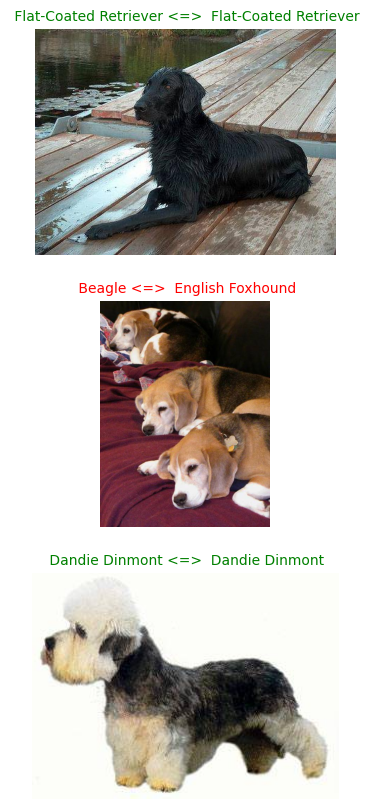

In [40]:
pred_and_plot(paths=test_data_paths,
              model=loaded_model,
              transform=transforms,
              class_names=class_names)

In [41]:
test_paths = random.sample(test_data_paths, k=10)

loaded_model_preds = pred_and_store(paths=test_paths,
                                    model=loaded_model,
                                    transform=transforms,
                                    class_names=class_names,
                                    device="cpu")

loaded_model_preds[:2]

  0%|          | 0/10 [00:00<?, ?it/s]

[{'image_path': PosixPath('drive/MyDrive/DogVision/myTest/dandie_dinmont/1ca968b47f96eae326ba0d7428584e6d.jpg'),
  'class_name': 'dandie_dinmont',
  'pred_prob': 0.8302,
  'pred_class': 'dandie_dinmont',
  'time_for_pred (s)': 0.4378,
  'correct': True},
 {'image_path': PosixPath('drive/MyDrive/DogVision/myTest/flat-coated_retriever/0d82788cd302dba65793ea68f55cc649.jpg'),
  'class_name': 'flat-coated_retriever',
  'pred_prob': 0.729,
  'pred_class': 'flat-coated_retriever',
  'time_for_pred (s)': 0.5095,
  'correct': True}]

In [42]:
loaded_model_pred_df = pd.DataFrame(loaded_model_preds)
loaded_model_pred_df

,image_path,class_name,pred_prob,pred_class,time_for_pred (s),correct
0,drive/MyDrive/DogVision/myTest/dandie_dinmont/...,dandie_dinmont,0.8302,dandie_dinmont,0.4378,True
1,drive/MyDrive/DogVision/myTest/flat-coated_ret...,flat-coated_retriever,0.7290,flat-coated_retriever,0.5095,True
2,drive/MyDrive/DogVision/myTest/dandie_dinmont/...,dandie_dinmont,0.8474,dandie_dinmont,0.5106,True
3,drive/MyDrive/DogVision/myTest/giant_schnauzer...,giant_schnauzer,0.9411,giant_schnauzer,0.4655,True
4,drive/MyDrive/DogVision/myTest/affenpinscher/f...,affenpinscher,0.2931,affenpinscher,0.5434,True
5,drive/MyDrive/DogVision/myTest/flat-coated_ret...,flat-coated_retriever,0.4384,flat-coated_retriever,0.5077,True
6,drive/MyDrive/DogVision/myTest/english_foxhoun...,english_foxhound,0.4670,english_foxhound,0.5068,True
7,drive/MyDrive/DogVision/myTest/flat-coated_ret...,flat-coated_retriever,0.7737,flat-coated_retriever,0.2241,True
8,drive/MyDrive/DogVision/myTest/affenpinscher/e...,affenpinscher,0.6739,affenpinscher,0.2327,True
9,drive/MyDrive/DogVision/myTest/giant_schnauzer...,giant_schnauzer,0.4108,giant_schnauzer,0.2207,True


In [43]:
loaded_model_pred_df.correct.value_counts()

True    10
Name: correct, dtype: int64

## Demo & Deploy

In [44]:
loaded_model.to("cpu")
next(iter(loaded_model.parameters())).device

device(type='cpu')

In [45]:
def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """
  start_time = timer()

  img = transforms(img).unsqueeze(0)

  loaded_model.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(loaded_model(img), dim=1)
    # print(pred_probs)

  pred_labels_and_probs = {class_names[i].title().replace("_", " "): float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 2)

  return pred_labels_and_probs, pred_time

In [46]:
random_image_path = random.sample(test_data_paths, k=1)[0]

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: drive/MyDrive/DogVision/myTest/flat-coated_retriever/0d82788cd302dba65793ea68f55cc649.jpg

Prediction label and probability dictionary: 
{'Affenpinscher': 0.003069981001317501, 'Afghan Hound': 0.00209596729837358, 'African Hunting Dog': 0.0005758199258707464, 'Airedale': 0.0003373872605152428, 'American Staffordshire Terrier': 0.0005642295582219958, 'Appenzeller': 0.0007815933204255998, 'Australian Terrier': 0.001724473899230361, 'Basenji': 0.0005615329137071967, 'Basset': 0.00046825926983729005, 'Beagle': 0.00038141690311022103, 'Bedlington Terrier': 0.0005819885991513729, 'Bernese Mountain Dog': 0.0017656220588833094, 'Black-And-Tan Coonhound': 0.0008383657550439239, 'Blenheim Spaniel': 0.0010369315277785063, 'Bloodhound': 0.0006620937492698431, 'Bluetick': 0.0005873710033483803, 'Border Collie': 0.0173847284168005, 'Border Terrier': 0.0003655710897874087, 'Borzoi': 0.0061648134142160416, 'Boston Bull': 0.0007158401422202587, 'Bouvier Des Flandres'

In [49]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=5)]
example_list

[['drive/MyDrive/DogVision/myTest/english_foxhound/2a8ac4ec28af4aa4bbb7e35dda82c6e0.jpg'],
 ['drive/MyDrive/DogVision/myTest/affenpinscher/fb56acfbe4b95a0df7a4b9e6bddbafd0.jpg'],
 ['drive/MyDrive/DogVision/myTest/giant_schnauzer/0ebfd68f64bd750fca790f0b40d69481.jpg'],
 ['drive/MyDrive/DogVision/myTest/affenpinscher/ebf9a3eab9607d1ef1aaaec90de886c9.jpg'],
 ['drive/MyDrive/DogVision/myTest/dandie_dinmont/0d579f92d60935a54aa6dba6e6213257.jpg']]

In [50]:
title = "Dog Breeds"
description = f"Model to classify dog breeds"
article = "© Amuni Pelumi https://www.amunipelumi.com/"

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=1, label="Breeds"),
                             gr.Number(label="Prediction Duration (S)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f67e34e28cd93c2bb7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [53]:
dog_breed_path = Path("demos/dog_breed/")
dog_breed_examples_path = dog_breed_path/"examples"
dog_breed_examples_path.mkdir(parents=True, exist_ok=True)

dog_breed_examples = [Path('drive/MyDrive/DogVision/myTest/english_foxhound/2a8ac4ec28af4aa4bbb7e35dda82c6e0.jpg'),
                      Path('drive/MyDrive/DogVision/myTest/affenpinscher/fb56acfbe4b95a0df7a4b9e6bddbafd0.jpg'),
                      Path('drive/MyDrive/DogVision/myTest/giant_schnauzer/0ebfd68f64bd750fca790f0b40d69481.jpg'),
                      Path('drive/MyDrive/DogVision/myTest/affenpinscher/ebf9a3eab9607d1ef1aaaec90de886c9.jpg'),
                      Path('drive/MyDrive/DogVision/myTest/dandie_dinmont/0d579f92d60935a54aa6dba6e6213257.jpg')]

for example in dog_breed_examples:
  destination = dog_breed_examples_path / example.name
  print(f"[INFO] Copied to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copied to demos/dog_breed/examples/2a8ac4ec28af4aa4bbb7e35dda82c6e0.jpg
[INFO] Copied to demos/dog_breed/examples/fb56acfbe4b95a0df7a4b9e6bddbafd0.jpg
[INFO] Copied to demos/dog_breed/examples/0ebfd68f64bd750fca790f0b40d69481.jpg
[INFO] Copied to demos/dog_breed/examples/ebf9a3eab9607d1ef1aaaec90de886c9.jpg
[INFO] Copied to demos/dog_breed/examples/0d579f92d60935a54aa6dba6e6213257.jpg


In [54]:
example_list = [["examples/" + example] for example in os.listdir(dog_breed_examples_path)]
example_list

[['examples/2a8ac4ec28af4aa4bbb7e35dda82c6e0.jpg'],
 ['examples/fb56acfbe4b95a0df7a4b9e6bddbafd0.jpg'],
 ['examples/0ebfd68f64bd750fca790f0b40d69481.jpg'],
 ['examples/0d579f92d60935a54aa6dba6e6213257.jpg'],
 ['examples/ebf9a3eab9607d1ef1aaaec90de886c9.jpg']]

In [55]:
saved_model_path = "drive/MyDrive/DogVision/models/effnetb3_dog_vision.pth"

destination = dog_breed_path / saved_model_path.split("/")[4]

try:
  print(f"[INFO] Copying model to {destination}")
  shutil.copy2(src=saved_model_path, dst=destination)
  print(f"[INFO] Model copy complete.")

except:
    print(f"[INFO] No model found at {saved_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {destination}: {destination.exists()}")

[INFO] Copying model to demos/dog_breed/effnetb3_dog_vision.pth
[INFO] Model copy complete.


In [56]:
%%writefile demos/dog_breed/model.py
import torch
import torchvision

from torch import nn


def create_model(num_classes=1000, seed=13):

  """Creates an EfficientNetB2 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier head.
          Defaults to 1000.
      seed (int, optional): random seed value. Defaults to 13.

  Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """

  weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
  auto_transforms = weights.transforms()
  model = torchvision.models.efficientnet_b3(weights=weights)

  manual_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    auto_transforms
  ])

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=num_classes)
  )

  return model, auto_transforms, manual_transforms

Writing demos/dog_breed/model.py


In [57]:
dog_breed_class_names_path = dog_breed_path / "class_names.txt"

with open(dog_breed_class_names_path, "w") as f:
  print(f"[INFO] Saving dog breed class names to {dog_breed_class_names_path}")
  f.write("\n".join(class_names))

[INFO] Saving dog breed class names to demos/dog_breed/class_names.txt


In [58]:
with open(dog_breed_class_names_path, "r") as f:
  dog_breed_class_names = [i.strip() for i in  f.readlines()]

dog_breed_class_names[:5], len(dog_breed_class_names)

(['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'],
 120)

In [59]:
%%writefile demos/dog_breed/app.py
import gradio as gr
import os
import torch

from model import create_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open("class_names.txt", "r") as f:
  class_names = [i.strip() for i in  f.readlines()]

model, auto_transforms, _ = create_model(len(class_names))

model.load_state_dict(
    torch.load(
        f="effnetb3_dog_vision.pth",
        map_location=torch.device("cpu")
    )
)

def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """

  start_time = timer()

  img = auto_transforms(img).unsqueeze(0)

  model.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(model(img), dim=1)

  pred_labels_and_probs = {class_names[i].title().replace("_", " "): float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 2)

  return pred_labels_and_probs, pred_time


title = "Dog Breed classifier"
description = f"This CV model aims to classify over 100 classes of various dog breeds. Utilizing EfficientNet as backbone."
article = "© Amuni Pelumi https://www.amunipelumi.com/"

example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=1, label="Top (5) Predictions"),
                             gr.Number(label="Prediction Duration (S)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch()

Writing demos/dog_breed/app.py


In [60]:
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

1.13.1+cu117
0.14.1+cu117
3.47.1


In [61]:
%%writefile demos/dog_breed/requirements.txt
torch==1.13.1
torchvision==0.14.1
gradio==3.47.1

Writing demos/dog_breed/requirements.txt


In [62]:
!ls demos/dog_breed/

app.py	class_names.txt  effnetb3_dog_vision.pth  examples  model.py  requirements.txt


In [ ]:
shutil.copy2(src="drive/MyDrive/Colab Notebooks/dog_breed.ipynb", dst="demos/dog_breed/dog_breed.ipynb")

'demos/foodvision_101/foodvision101.ipynb'

In [ ]:
!ls demos/dog_breed/

app.py		 effnetb2_feature_extractor_food101.pth  foodvision101.ipynb  modular
class_names.txt  examples				 model.py	      requirements.txt


In [ ]:
!cd demos/dog_breed && zip -r dog_breed.zip * -x "*.pyc" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 53%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb2_feature_extractor_food101.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/3867527.jpg (deflated 0%)
  adding: examples/323909.jpg (deflated 2%)
  adding: examples/1479513.jpg (deflated 1%)
  adding: examples/3805789.jpg (deflated 0%)
  adding: examples/1975481.jpg (deflated 1%)
  adding: foodvision101.ipynb (deflated 33%)
  adding: model.py (deflated 52%)
  adding: modular/ (stored 0%)
  adding: modular/data_setup.py (deflated 66%)
  adding: modular/utils.py (deflated 57%)
  adding: modular/engine.py (deflated 74%)
  adding: modular/model_builder.py (deflated 67%)
  adding: modular/assist.py (deflated 65%)
  adding: modular/train.py (deflated 57%)
  adding: modular/predictions.py (deflated 62%)
  adding: requirements.txt (deflated 4%)
